In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# GARCH Model

> Step-by-step guide on using the `GARCH Model` with `Statsforecast`.

In this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation`.

## Table of Contents

* [Introduction](#introduction)
* [GARCH Models](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of GARCH with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>


The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is a statistical technique used to model and predict volatility in financial and economic time series. It was developed by Robert Engle in 1982 as an extension of the Autoregressive Conditional Heteroskedasticity (ARCH) model proposed by Andrew Lo and Craig MacKinlay in 1988.

The GARCH model allows capturing the presence of conditional heteroscedasticity in time series data, that is, the presence of fluctuations in the variance of a time series as a function of time. This is especially useful in financial data analysis, where volatility can be an important measure of risk.

The GARCH model has become a fundamental tool in the analysis of financial time series and has been used in a wide variety of applications, from risk management to forecasting prices of shares and other financial values.

## Definition of GARCH Models <a class="anchor" id="model"></a>

**Definition 1.** A $\text{GARCH}(p,q)$ model with order $(p≥1,q≥0)$ is of the form

\begin{equation}
    \left\{
	    \begin{array}{ll}
		 X_t =\sigma_t \varepsilon_t      \\
		 \sigma_{t}^2 =\omega+ \sum_{i=1}^{p} \alpha_i X_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2 \\
	    \end{array}
	\right.
\end{equation}

where $\omega ≥0,\alpha_i ≥0,\beta_j ≥0,\alpha_p >0$ ,and $\beta_q >0$ are constants,$\varepsilon_t \sim iid(0,1)$, and $\varepsilon_t$ is independent of $\{X_k;k ≤ t − 1 \}$. A stochastic process $X_t$ is called a $\text{GARCH}(p, q )$ process if it satisfies Eq. (1).

In practice, it has been found that for some time series, the $\text{ARCH}(p)$ model defined by (1) will provide an adequate fit only if the order $p$ is large. By allowing past volatilities to affect the present volatility in (1), a more parsimonious model may result. That is why we need `GARCH` models. Besides, note the condition that the order $p ≥ 1$. The **GARCH model** in Definition 1 has the properties as follows.

Proposition 1. If $X_t$ is a $\text{GARCH}(p, q)$ process defined in (1) and $\sum_{i=1}^{p} \alpha_{i} + \sum_{j=1}^{q} \beta_j <1$,then the following propositions hold.

* $X_{t}^2$ follows the $\text{ARMA}(m, q )$ model

$$X_{t}^2=\omega +\sum_{i=1}^{m} (\alpha_i + \beta_i )X_{t-i}^2 + \eta_t − \sum_{j=1}^q \beta_j \eta_{t-j} $$

where $\alpha_i =0$ for $i >p,βj =0$  for  $j >q,m=max(p,q)$, and $\eta_t =\sigma_{t}^2 (\varepsilon_{t}^2 −1)$.

* $X_t$ is a white noise with

$$E(X)=0, E(X_{t+h} X_t )=0 \ \ \text{for} \ any \ \ h \neq 0, Var(X_t)= \frac{\omega}{1-\sum_{i=1}^{m} (\alpha_i + \beta_i )} $$

* $\sigma_{t}^2$ is the conditional variance of $X_t$ , that is, we have

$$E(X_t|\mathscr{F}_{t−1}) = 0, \sigma_{t}^2 = Var(X_{t}^2|\mathscr{F}_{t−1}).$$

* Model (1) reflects the fat tails and volatility clustering.


Although an asset return series can usually be seen as a white noise, there exists such a return series so that it may be autocorrelated. What is more, a given original time series is not necessarily a return series, and at the same time, its values may be negative. If a time series is autocorrelated, we must first build an adequate model (e.g., an ARMA model) for the series in order to remove any autocorrelation in it. Then check whether the residual series has an ARCH effect, and if yes then we further model the residuals. In other words, if a time series $Y_t$ is autocorrelated and has ARCH effect, then a GARCH model that can capture the features of $Y_t$t should be of the form

\begin{equation}
    \left\{
	    \begin{array}{ll}
		 Y_t =f(Z_t,Y_{t−1},X_{t−1},Y_{t−2},X_{t−2},\cdots )+X_t   \tag 2,  \\
		 X_t = \sigma_t \varepsilon_t, \\
		 \sigma_{t}^2 =\omega+ \sum_{i=1}^{p} \alpha_i X_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2   \ \  \ \   \   \  (3)  \\
	    \end{array}
	\right.
\end{equation}

where Eq. (2) is referred to as the mean equation (model) and Eq. (3) is known as the volatility (variance) equation (model), and $Z_t$ is a representative of exogenous regressors. If $Y_t$ is a return series, then typically $Y_t = r + X_t$ where $r$ is a constant that means the expected returns is fixed.

### Advantages and disadvantages of the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Model

|Advantages|Disadvantages|
|----------|-------------|
|1. 1. Flexible model: The GARCH model is flexible and can fit different types of time series data with different volatility patterns.|1. Requires a large amount of data: The GARCH model requires a large amount of data to accurately estimate the model parameters.|
|2. Ability to model volatility: The GARCH model is capable of modeling the volatility and heteroscedasticity of a time series, which can improve the accuracy of forecasts.|2. Sensitive to the model specification: The GARCH model is sensitive to the model specification and can be difficult to estimate if incorrectly specified.|
|3. It incorporates past information: The GARCH model incorporates past information on the volatility of the time series, which makes it useful for predicting future volatility.|3. It can be computationally expensive: The GARCH model can be computationally expensive, especially if more complex models are used.|
|4. Allows the inclusion of exogenous variables: The GARCH model can be extended to include exogenous variables, which can improve the accuracy of the predictions.| 4. It does not consider extreme events: The GARCH model does not consider extreme or unexpected events in the time series, which can affect the accuracy of the predictions in situations of high volatility.|
|5. The GARCH model makes it possible to model conditional heteroscedasticity, that is, the variation of the variance of a time series as a function of time and of the previous values of the time series itself.| 5. The GARCH model assumes that the time series errors are normally distributed, which may not be true in practice. If the errors are not normally distributed, the model may produce inaccurate estimates of volatility.|
|6. The GARCH model can be used to estimate the value at risk (VaR) and the conditional value at risk (CVaR) of an investment portfolio.|








### The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model can be applied in several fields

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model can be applied in a wide variety of areas where time series volatility is required to be modeled and predicted. Some of the areas in which the GARCH model can be applied are:

1. **Financial markets:** the GARCH model is widely used to model the volatility (risk) of returns on financial assets such as stocks, bonds, currencies, etc. It allows you to capture the changing nature of volatility.

2. **Commodity prices:** the prices of raw materials such as oil, gold, grains, etc. they exhibit conditional volatility that can be modeled with GARCH.

3. **Credit risk:** the risk of non-payment of loans and bonds also presents volatility over time that suits GARCH well.

4. **Economic time series:** macroeconomic indicators such as inflation, GDP, unemployment, etc. they have conditional volatility modelable with GARCH.

5. **Implicit volatility:** the GARCH model allows estimating the implicit volatility in financial options.

6. **Forecasts:** GARCH allows conditional volatility forecasts to be made in any time series.

7. **Risk analysis:** GARCH is useful for measuring and managing the risk of investment portfolios and assets.

8. **Finance:** The GARCH model is widely used in finance to model the price volatility of financial assets, such as stocks, bonds, and currencies.

9. **Economics:** The GARCH model is used in economics to model the volatility of the prices of goods and services, inflation, and other economic indicators.

10. **Environmental sciences:** The GARCH model is applied in environmental sciences to model the volatility of variables such as temperature, precipitation, and air quality.

11. **Social sciences:** The GARCH model is used in the social sciences to model the volatility of variables such as crime, migration, and employment.

12. **Engineering:** The GARCH model is applied in engineering to model the volatility of variables such as the demand for electrical energy, industrial production, and vehicular traffic.

13. **Health sciences:** The GARCH model is used in health sciences to model the volatility of variables such as the number of cases of infectious diseases and the prices of medicines.

The GARCH Model is applicable in any context where it is required to model and forecast heterogeneous conditional volatility in time series, especially in finance and economics.



## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

Let's pull the S&P500 stock data from the Yahoo Finance site.

In [ ]:
import pandas as pd
import time
from datetime import datetime

ticker = '^GSPC'
period1 = int(time.mktime(datetime(2015, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.now().timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

SP_500 = pd.read_csv(query_string)
SP_500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [ ]:
df=SP_500[["Date","Close"]]

The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2015-01-02,2058.199951,1
1,2015-01-05,2020.579956,1
2,2015-01-06,2002.609985,1
3,2015-01-07,2025.900024,1
4,2015-01-08,2062.139893,1


In [ ]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore data with the plot method <a class="anchor" id="plotting"></a>

Plot a series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

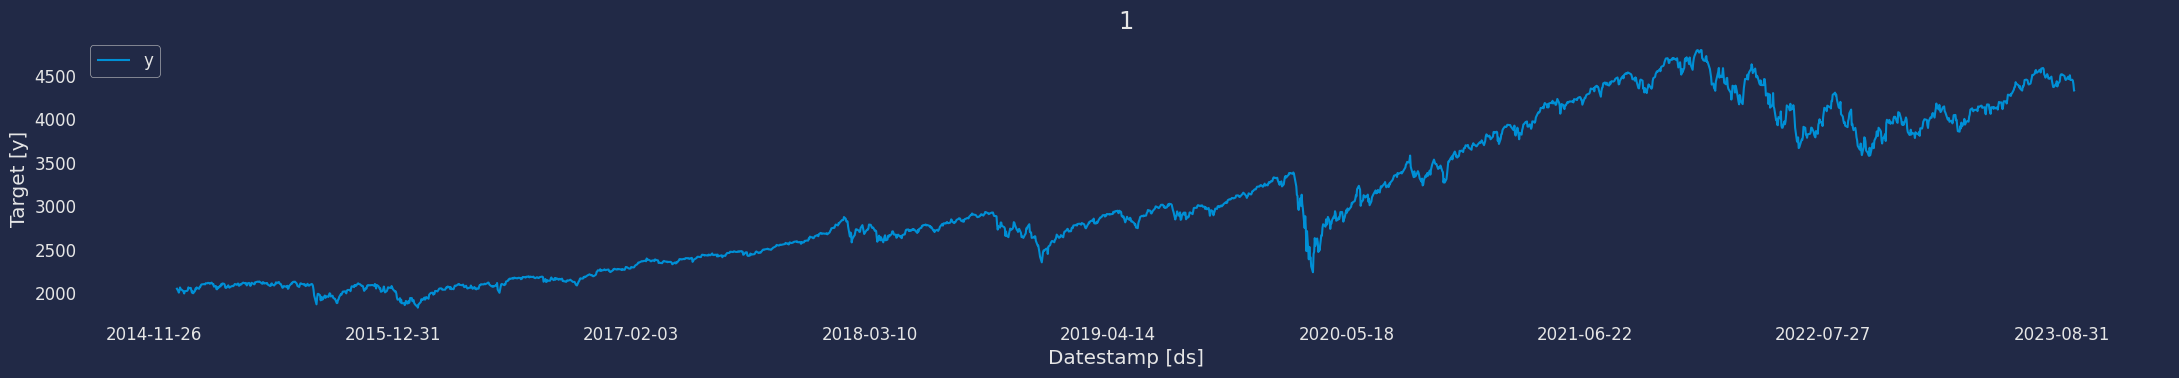

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

Let's check if our series that we are analyzing is a stationary series. Let's create a function to check, using the `Dickey Fuller` test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'S&P500')

Dickey-Fuller test results for columns: S&P500
Test Statistic          -0.787511
p-value                  0.822763
No Lags Used            10.000000
                          ...    
Critical Value (1%)     -3.433346
Critical Value (5%)     -2.862864
Critical Value (10%)    -2.567475
Length: 7, dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


In the previous result we can see that the `Augmented_Dickey_Fuller` test gives us a `p-value` of 0.864700, which tells us that the null hypothesis cannot be rejected, and on the other hand the data of our series are not stationary.

We need to differentiate our time series, in order to convert the data to stationary.

### Return Series

Since the 1970s, the financial industry has been very prosperous with advancement of computer and Internet technology. Trade of financial products (including various derivatives) generates a huge amount of data which form financial time series. For finance, the return on a financial product is most interesting, and so our attention focuses on the return series. If {Pt } is the closing price at time t for a certain financial product, then the return on this product is

$$X_t = \frac{(P_t − P_{t−1})}{P_{t−1}} ≈ log(P_t ) − log(P_{t−1}).$$

It is return series $\{X_t \}$ that have been much independently studied. And important stylized features which are common across many instruments, markets, and time periods have been summarized. Note that if you purchase the financial product, then it becomes your asset, and its returns become your asset returns. Now let us look at the following examples.

We can estimate the series of returns using the [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html), `DataFrame.pct_change()` function. The `pct_change()` function has a periods parameter whose default value is 1. If you want to calculate a 30-day return, you must change the value to 30.

In [ ]:
df['return'] = 100 * df["y"].pct_change()
df.dropna(inplace=True, how='any')
df.head()

,ds,y,unique_id,return
1,2015-01-05,2020.579956,1,-1.827811
2,2015-01-06,2002.609985,1,-0.889347
3,2015-01-07,2025.900024,1,1.162984
4,2015-01-08,2062.139893,1,1.788828
5,2015-01-09,2044.810059,1,-0.840381


In [ ]:
import plotly.express as px
fig = px.line(df, x=df["ds"], y="return",title="SP500 Return Chart",template = "plotly_dark")
fig.show()

### Creating Squared Returns

In [ ]:
df['sq_return'] = df["return"].mul(df["return"])
df.head()

,ds,y,unique_id,return,sq_return
1,2015-01-05,2020.579956,1,-1.827811,3.340891
2,2015-01-06,2002.609985,1,-0.889347,0.790938
3,2015-01-07,2025.900024,1,1.162984,1.352532
4,2015-01-08,2062.139893,1,1.788828,3.199906
5,2015-01-09,2044.810059,1,-0.840381,0.706240


### Returns vs Squared Returns

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(x=df["ds"], y=df["return"],
                         mode='lines',
                         name='return'),
row=1, col=1
)


fig.add_trace(go.Scatter(x=df["ds"], y=df["sq_return"],
                         mode='lines',
                         name='sq_return'), 
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Returns vs Squared Returns", template = "plotly_dark")
fig.show()

In [ ]:
from scipy.stats import probplot, moment
from statsmodels.tsa.stattools import adfuller, q_stat, acf
import numpy as np
import seaborn as sns

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Return')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title+ f'Dickey-Fuller: {adfuller(x)[1]:>11.2f}', fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

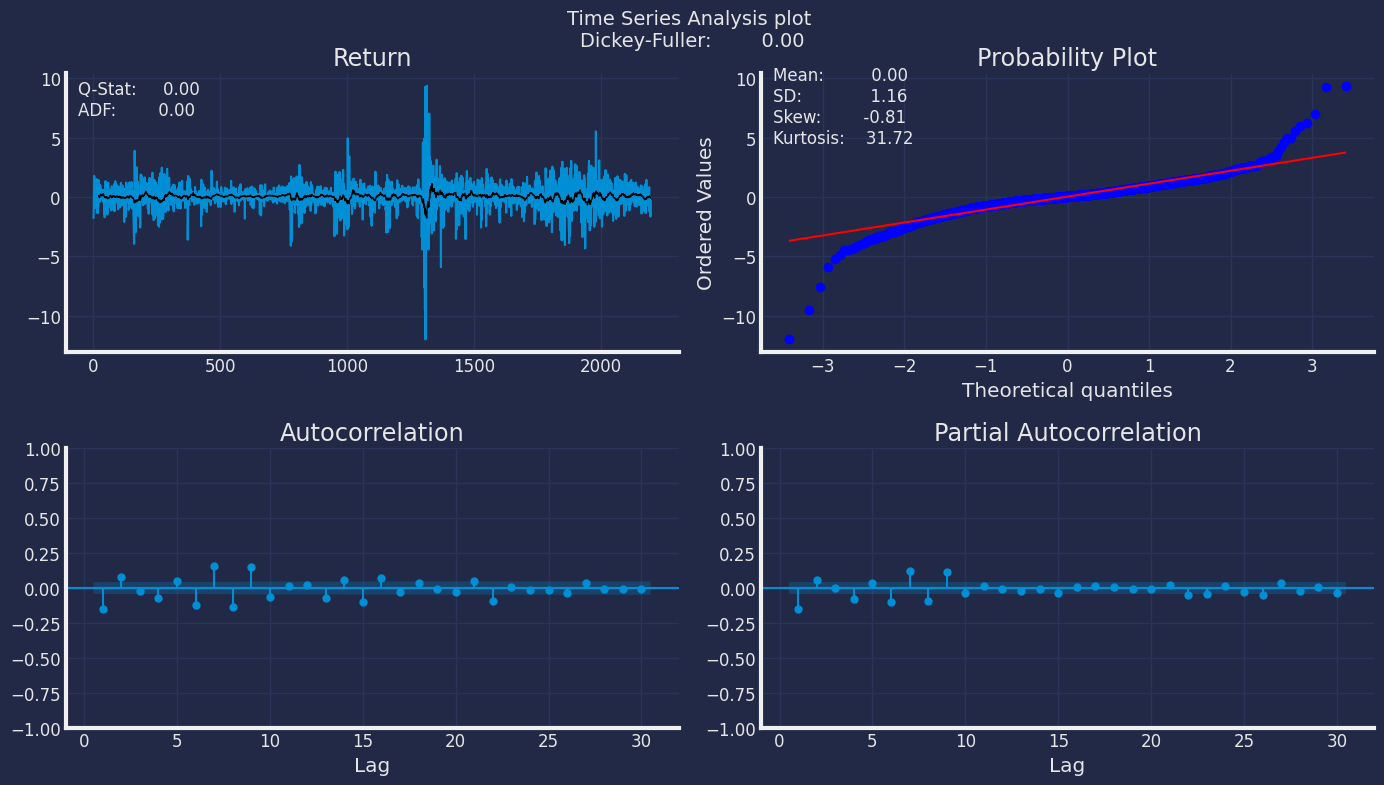

In [ ]:
plot_correlogram(df["return"], lags=30, title="Time Series Analysis plot \n") 

### Ljung-Box Test

Ljung-Box is a test for autocorrelation that we can use in tandem with our ACF and PACF plots. The Ljung-Box test takes our data, optionally either lag values to test, or the largest lag value to consider, and whether to compute the Box-Pierce statistic. Ljung-Box and Box-Pierce are two similar test statisitcs,  Q , that are compared against a chi-squared distribution to determine if the series is white noise. We might use the Ljung-Box test on the residuals of our model to look for autocorrelation, ideally our residuals would be white noise.

- Ho : The data are independently distributed, no autocorrelation.
- Ha : The data are not independently distributed; they exhibit serial correlation.

The Ljung-Box with the Box-Pierce option will return, for each lag, the Ljung-Box test statistic, Ljung-Box p-values, Box-Pierce test statistic, and Box-Pierce p-values.

If  $p<\alpha  (0.05)$ we reject the null hypothesis.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_res = acorr_ljungbox(df["return"], lags= 40, boxpierce=True)

ljung_res.head()

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,49.084018,2.452302e-12,49.016994,2.537545e-12
2,62.974905,2.114331e-14,62.882591,2.214211e-14
3,64.003767,8.192843e-14,63.909110,8.583753e-14
4,74.532698,2.501770e-15,74.409287,2.656714e-15
5,80.462889,6.714400e-16,80.320584,7.190906e-16


## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `GARCH` model
2. Data to test our model

For the test data we will use the last 30 day to test and evaluate the performance of our model.

In [ ]:
df=df[["ds","unique_id","return"]]
df.columns=["ds", "unique_id", "y"]

In [ ]:
train = df[df.ds<='2023-05-31'] # Let's forecast the last 30 days
test = df[df.ds>'2023-05-31']

In [ ]:
train.shape, test.shape

((2116, 3), (79, 3))

Now let's plot the training data and the test data.

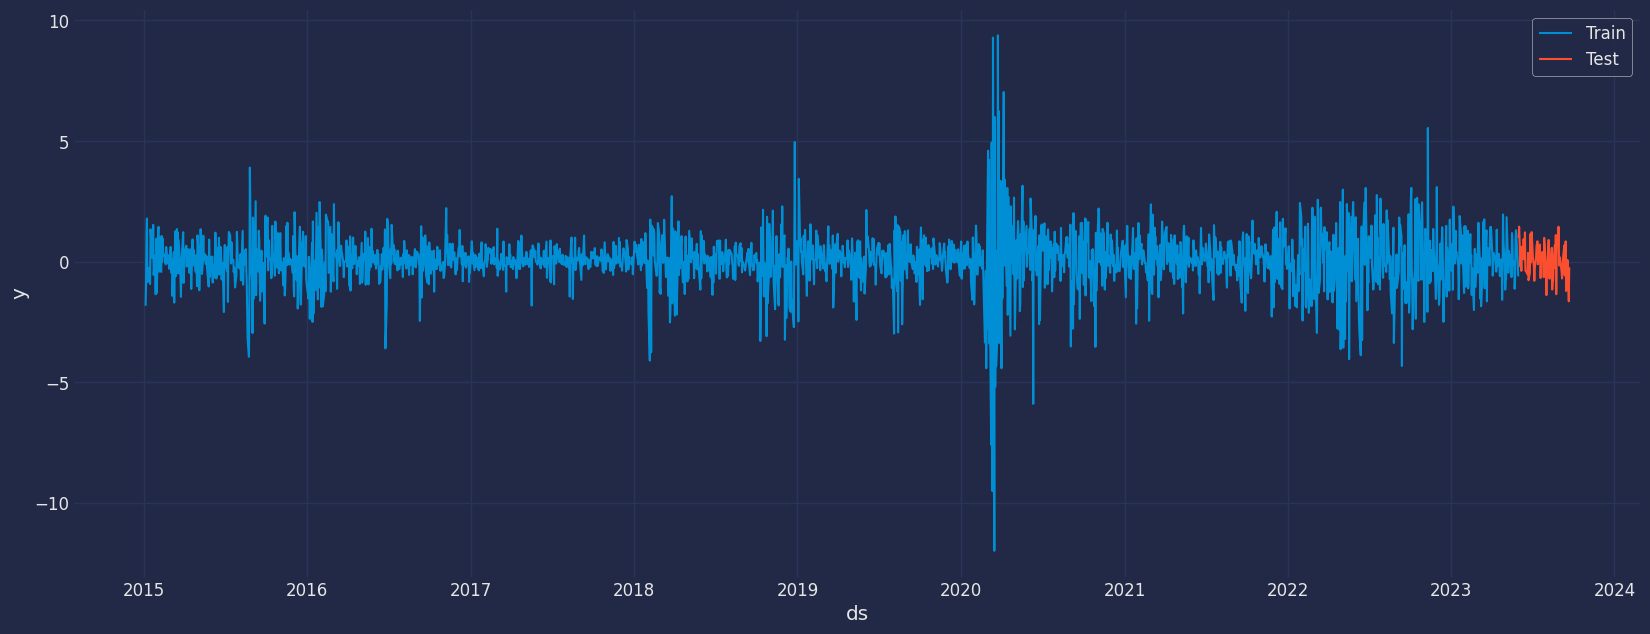

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

## Implementation of GARCH with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `GARCH Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#garch-model)

```
p : int
    Number of lagged versions of the series.
q: int
    Number of lagged versions of the volatility.
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast 
from statsforecast.models import GARCH 

### Instantiating Models
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful.season_length.

In [ ]:
season_length = 7 # Dayly data 
horizon = len(test) # number of predictions biasadj=True, include_drift=True,

models = [GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          GARCH(3,1),
          GARCH(3,2),
          GARCH(3,3), 
          GARCH(1,3), 
          GARCH(2,3)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='C', # custom business day frequency
                   n_jobs=-1)

## Cross-validation <a class="anchor" id="cross_validate"></a>

We have built different GARCH models, so we need to determine which is the best model to then be able to train it and thus be able to make the predictions. To know which is the best model we go to the Cross Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=6,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)","GARCH(3,1)","GARCH(3,2)","GARCH(3,3)","GARCH(1,3)","GARCH(2,3)"
unique_id,,,,,,,,,,,,
1,2023-01-09,2023-01-06,-0.400055,1.837775,1.800840,1.837657,1.871248,2.445847,1.863877,1.784033,1.817171,1.818214
1,2023-01-10,2023-01-06,0.753897,-0.795351,-0.806296,-0.797953,-0.797834,-0.915207,-0.791588,-0.806350,-0.800440,-0.792509
1,2023-01-11,2023-01-06,-1.164553,-0.642657,-0.628474,-0.642989,-0.659150,-0.820354,-0.662257,-0.627043,-0.638063,-0.647439
...,...,...,...,...,...,...,...,...,...,...,...,...
1,2023-05-29,2023-02-09,1.304909,-0.326682,-0.337108,-0.329423,-0.329929,-0.334541,-0.327339,-0.329837,-0.337829,-0.482515
1,2023-05-30,2023-02-09,0.001660,0.807002,0.786141,0.807191,0.841059,0.811327,0.835608,0.771174,0.800778,1.519543
1,2023-05-31,2023-02-09,-0.610862,0.219055,0.219215,0.220126,0.225557,0.228682,0.218639,0.214887,0.215073,0.333732


In [ ]:
from datasetsforecast.losses import rmse

def compute_cv_rmse(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = rmse(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)

In [ ]:
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 
rmse_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_rmse)

mae = rmse_cv.groupby('unique_id').mean()
mae.style.highlight_min(color = 'red', axis = 1)

,"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)","GARCH(3,1)","GARCH(3,2)","GARCH(3,3)","GARCH(1,3)","GARCH(2,3)"
unique_id,,,,,,,,,
1,1.300764,1.973023,1.380985,1.308715,1.380751,1.367080,1.301468,1.306386,1.386207


**Note:** This result can vary depending on the data and period you use to train and test the model, and the models you want to test. This is an example, where the objective is to be able to teach a methodology for the use of `StatsForecast`, and in particular the GARCH model and the parameters used in Cross Validation to determine the best model for this example.

In the previous result it can be seen that the best model is the model $\text{GARCH}(1,1)$

With this result found using Cross Validation to determine which is the best model, we are going to continue training our model, to then make the predictions.

### Fit the Model

In [ ]:
season_length = 7 # Dayly data 
horizon = len(test) # number of predictions biasadj=True, include_drift=True,

models = [GARCH(1,1)]

In [ ]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='C', # custom business day frequency
                   n_jobs=-1)

In [ ]:
sf.fit()

StatsForecast(models=[GARCH(1,1)])

Let's see the results of our Theta model. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'p': 1,
 'q': 1,
 'coeff': array([0.11715665, 0.261296  , 0.64151786]),
 'message': 'Optimization terminated successfully',
 'y_vals': array([-0.61086244]),
 'sigma2_vals': array([0.81241364]),
 'fitted': array([        nan,  2.22688619, -0.75658963, ..., -0.20975516,
         0.83589047,  0.1360351 ]),
 'actual_residuals': array([        nan, -3.11623338,  1.91957389, ...,  1.51466384,
        -0.83423013, -0.74689754])}

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("actual_residuals"), columns=["residual Model"])
residual

,residual Model
0,NaN
1,-3.116233
2,1.919574
...,...
2113,1.514664
2114,-0.834230
2115,-0.746898


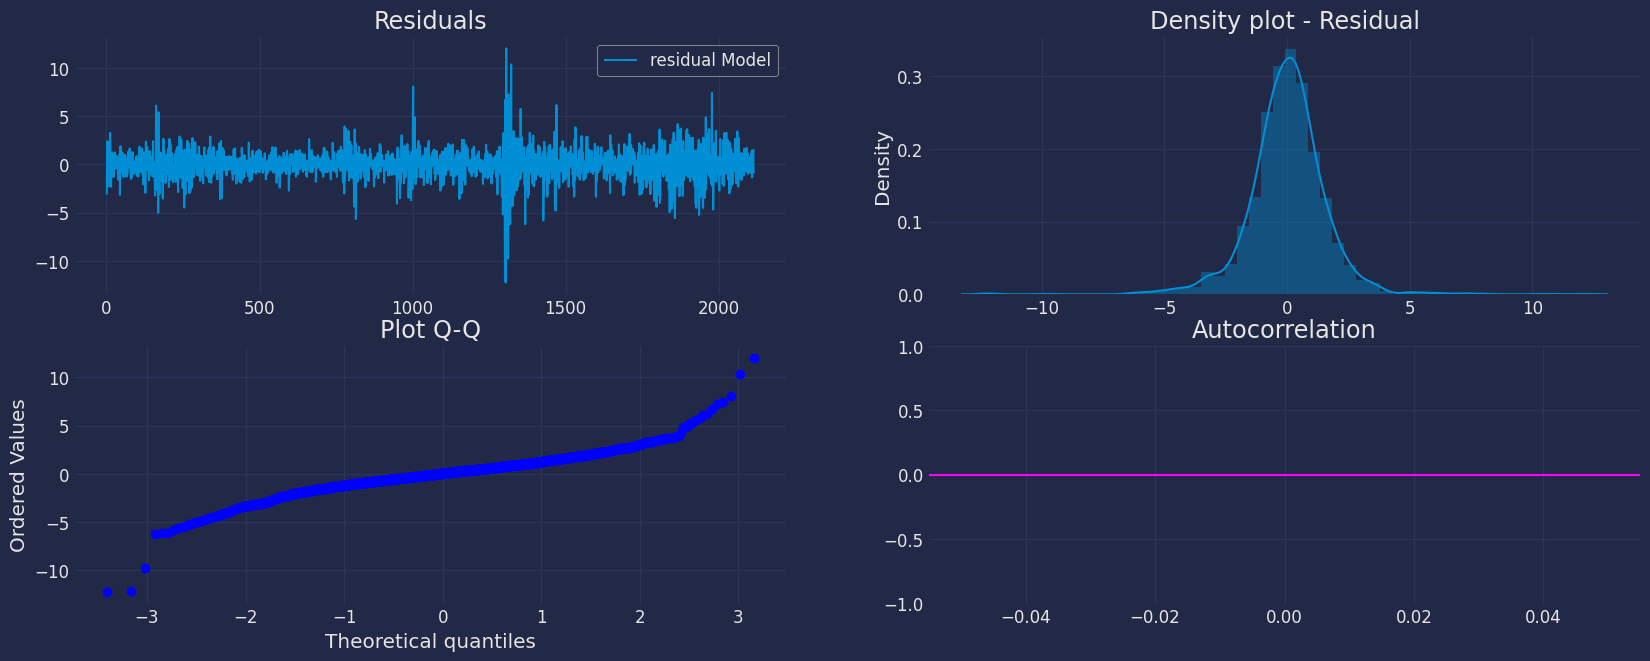

In [ ]:
from scipy import stats

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat.head()

,ds,"GARCH(1,1)"
unique_id,,
1,2023-06-01,1.393380
1,2023-06-02,-0.640599
1,2023-06-05,-0.508753
1,2023-06-06,-0.947621
1,2023-06-07,0.798889


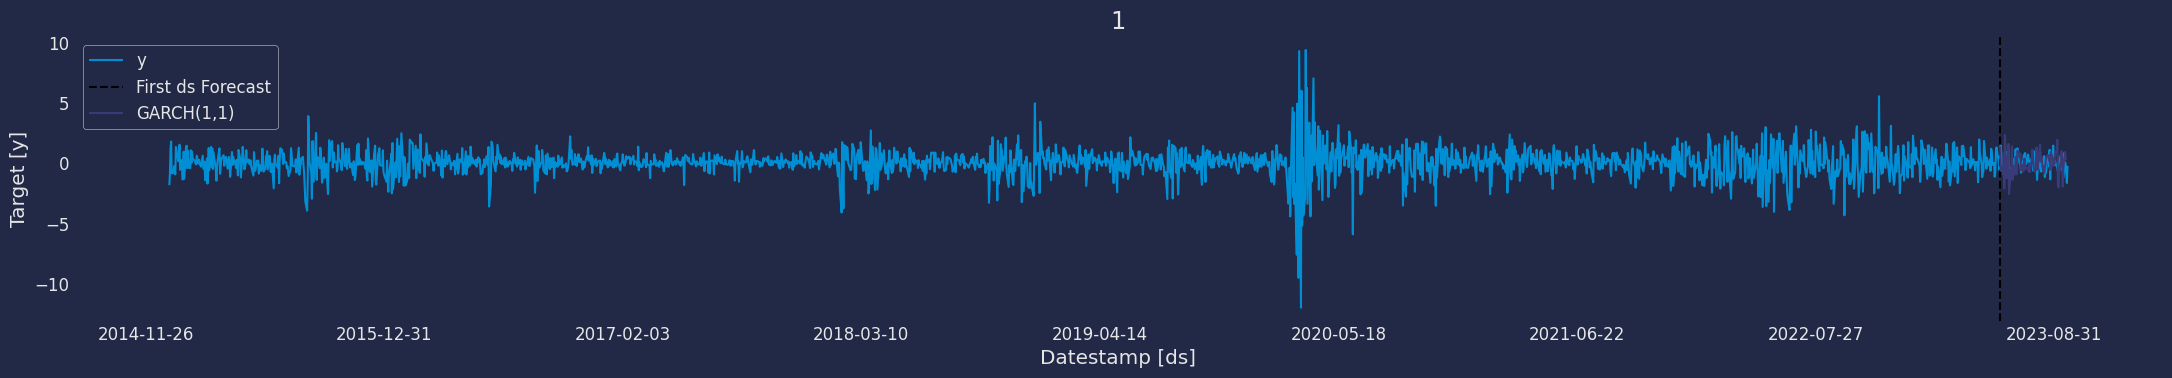

In [ ]:
sf.plot(df, Y_hat, level=[95])

In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,"GARCH(1,1)"
unique_id,,,
1,2015-01-05,-1.827811,NaN
1,2015-01-06,-0.889347,2.226886
1,2015-01-07,1.162984,-0.756590
1,2015-01-08,1.788828,-0.636398
1,2015-01-09,-0.840381,-1.472993


Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(h=horizon, level=[95])

,ds,"GARCH(1,1)","GARCH(1,1)-lo-95","GARCH(1,1)-hi-95"
unique_id,,,,
1,2023-06-01,1.393380,-0.048836,2.835595
1,2023-06-02,-0.640599,-2.789734,1.508536
1,2023-06-05,-0.508753,-2.327246,1.309740
...,...,...,...,...
1,2023-09-15,-0.400229,-3.748684,2.948225
1,2023-09-18,0.927553,-1.532199,3.387304
1,2023-09-19,0.246434,-2.001777,2.494645


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat.head()

,unique_id,ds,"GARCH(1,1)"
0,1,2023-06-01,1.393380
1,1,2023-06-02,-0.640599
2,1,2023-06-05,-0.508753
3,1,2023-06-06,-0.947621
4,1,2023-06-07,0.798889


In [ ]:
# Merge the forecasts with the true values
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,unique_id,y,"GARCH(1,1)"
0,2023-06-01,1,0.985445,1.393380
1,2023-06-02,1,1.453442,-0.640599
2,2023-06-05,1,-0.200358,-0.508753
...,...,...,...,...
76,2023-09-20,1,-0.939479,NaN
77,2023-09-21,1,-1.640093,NaN
78,2023-09-22,1,-0.229560,NaN


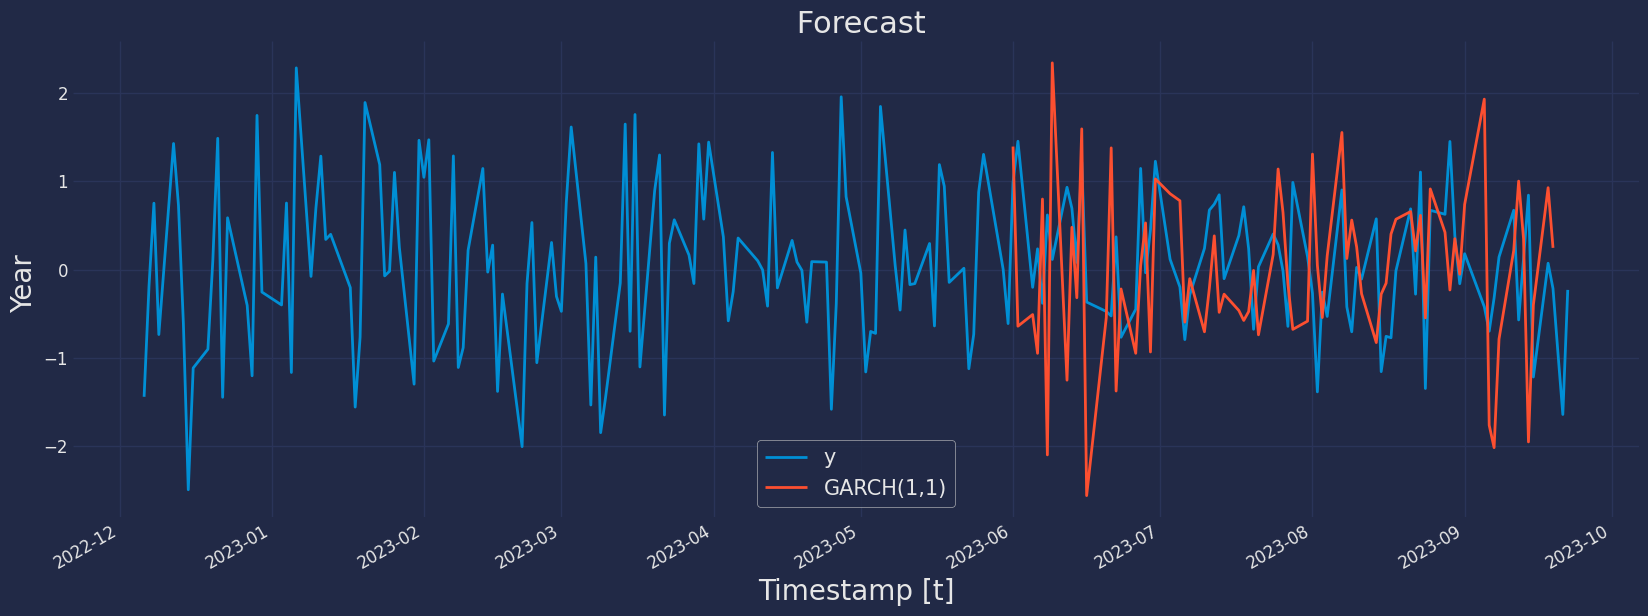

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds').tail(200)
plot_df[['y', "GARCH(1,1)"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case,  30 dayly ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,ds,"GARCH(1,1)"
unique_id,,
1,2023-06-01,1.393380
1,2023-06-02,-0.640599
1,2023-06-05,-0.508753
...,...,...
1,2023-09-15,-0.400229
1,2023-09-18,0.927553
1,2023-09-19,0.246434


In [ ]:
forecast_df = sf.predict(h=horizon, level=[80,95]) 

forecast_df.head(10)

,ds,"GARCH(1,1)","GARCH(1,1)-lo-95","GARCH(1,1)-lo-80","GARCH(1,1)-hi-80","GARCH(1,1)-hi-95"
unique_id,,,,,,
1,2023-06-01,1.393380,-0.048836,0.450365,2.336394,2.835595
1,2023-06-02,-0.640599,-2.789734,-2.045843,0.764645,1.508536
1,2023-06-05,-0.508753,-2.327246,-1.697802,0.680296,1.309740
...,...,...,...,...,...,...
1,2023-06-12,-1.251548,-6.549860,-4.715928,2.212832,4.046764
1,2023-06-13,0.479689,-3.951083,-2.417437,3.376815,4.910460
1,2023-06-14,-0.318133,-3.508017,-2.403886,1.767620,2.871751


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot

,unique_id,y,"GARCH(1,1)","GARCH(1,1)-lo-95","GARCH(1,1)-lo-80","GARCH(1,1)-hi-80","GARCH(1,1)-hi-95"
ds,,,,,,,
2023-03-03,1.0,1.614774,NaN,NaN,NaN,NaN,NaN
2023-03-06,1.0,0.068717,NaN,NaN,NaN,NaN,NaN
2023-03-07,1.0,-1.532692,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-09-15,NaN,NaN,-0.400229,-3.748684,-2.589666,1.789208,2.948225
2023-09-18,NaN,NaN,0.927553,-1.532199,-0.680792,2.535898,3.387304
2023-09-19,NaN,NaN,0.246434,-2.001777,-1.223592,1.716460,2.494645


In [ ]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2 )
    colors = ['green']
  # Specify graph features:
    ax.fill_between(df_plot.index, 
                df_plot['GARCH(1,1)-lo-80'], 
                df_plot['GARCH(1,1)-hi-80'],
                alpha=.20,
                color='lime',
                label='GARCH(1,1)_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['GARCH(1,1)-lo-95'], 
                df_plot['GARCH(1,1)-hi-95'],
                alpha=.2,
                color='white',
                label='GARCH(1,1)_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Return", fontsize=20)
    ax.set_xlabel('Month-Days', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid(True)
    plt.show()

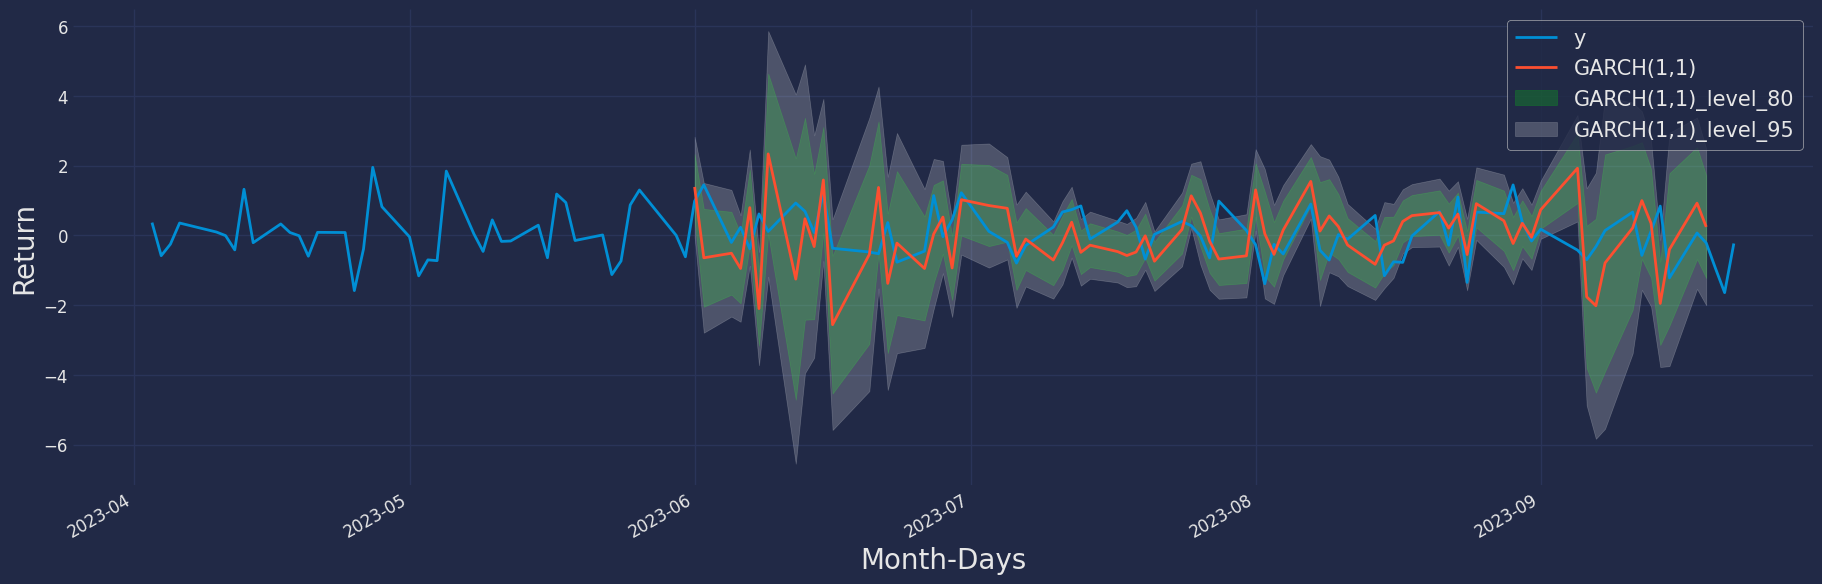

In [ ]:
plot_forecasts(train, test, forecast_df, models=["GARCH(1,1)" ])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

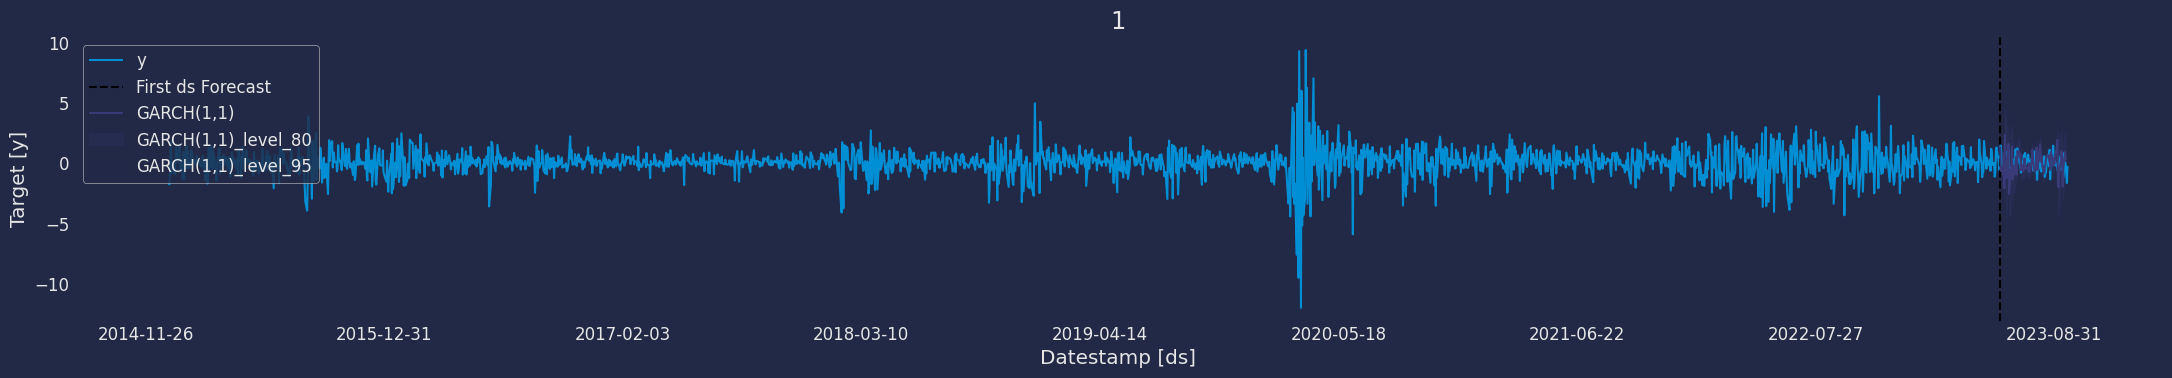

In [ ]:
sf.plot(df, forecast_df, level=[80,95])

## Model Evaluation <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `GARCH`.

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics `MAE, MAPE, MASE, RMSE, SMAPE` to evaluate the `accuracy`.

In [ ]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred, model):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name =='mase':
            evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                y_true[model].values, 
                                                y_hist['y'].values, seasonality=7)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [ ]:
evaluate_performace(train, test, Y_hat, model="GARCH(1,1)")

,mae,mape,mase,rmse,smape
"GARCH(1,1)",0.888456,386.879212,NaN,1.108889,137.237703


## Acknowledgements

We would like to thank [Naren Castellon](https://www.linkedin.com/in/naren-castellon-1541b8101/?originalSubdomain=pa) for writing this tutorial.

## References <a class="anchor" id="references"></a>


1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7da8bfa5295375c1141d797e80065a599153c19d)
2. [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf).
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).